In [1]:
###噪声注入y数据
import random
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import pandas as pd
#import imageio
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline
import math

SEED = 1234#固定种子，大家都可以重复结果
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True

x = torch.unsqueeze(torch.linspace(-1, 1, 21), dim=1)
ytrain = torch.sin(math.pi*x) + 0.2*torch.randn(x.size())  # 这里是污染数据固定不变当成训练数据

#噪声注入输入数据方法
#对于训练数据ytrain
epoch = 20000 #一次训练步长数目
NJnum=30 #对于每个注入噪声强度sigma，仿真次数为NJnum

In [2]:
class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        x = self.predict(x)  # 前向传播过程
        return x  

    def reset_parameters(self):
        # 重新初始化网络参数
        self.hidden1.reset_parameters()
        self.predict.reset_parameters()
#经典的sigmoid神经网络1*n_hidden1*1，中间隐层为sigmoid函数
#这里把Net Class放在循环外面，对于不同的噪声注入数据，采用net.reset_parameters()对于网络进行重置

net = Net(n_feature=1, n_hidden1=10, n_output=1)#定义1*10*1的网络
device = torch.device('cpu')#cpu计算
optimizer = torch.optim.Adam(net.parameters(), lr=0.01,betas=(0.96,0.96))
#Adam算法，学习率是固定的0.01，矩参数是0.96
loss_func = torch.nn.MSELoss().to(device)  # loss函数是均方误差mse

In [3]:
#选择sigma
from tqdm import tqdm

sigma = 0.01  # 人工选择加入噪声均方根为0.01
losses = []  # 用于存储每次训练的损失，共NJnum个
x = x.to(device)
inputx = torch.unsqueeze(torch.linspace(-1, 1, 401), dim=1).to(device)
output = torch.zeros(inputx.shape).to(device)


for num in range(NJnum):
    
    SEED = 1234 + 12 * num  
    np.random.seed(SEED)
    random.seed(SEED) 
    
    #x_noisy = x + sigma * torch.randn(x.size()).to(device)
    #ytrain = ytrain.to(device)#这是噪声注入x的代码
    
    y_noisy = ytrain + sigma * torch.randn(x.size()).to(device)
    #改变y，就是噪声注入标签
    progress_bar = tqdm(range(epoch), desc=f'NJnum {num}/{NJnum}')
    net.reset_parameters()
    for t in progress_bar:
        prediction = net(x)
        loss = loss_func(prediction, y_noisy)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        if t % 200 == 0:
            progress_bar.set_postfix({'loss': loss.item()})
    #epoch=20000步之后网络输出和最后一步训练之后的loss
    response = net(inputx)
    output += response
    losses.append(loss.item())  # 记录每次训练的损失
# 平均损失
average_loss = sum(losses) / NJnum
print("average_loss =", average_loss)
#平均网络输出
output /= NJnum

NJnum 29/30: 100%|████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1683.26it/s, loss=0.0101]

average_loss = 0.006274203718445884


In [4]:
average_loss

0.006274203718445884

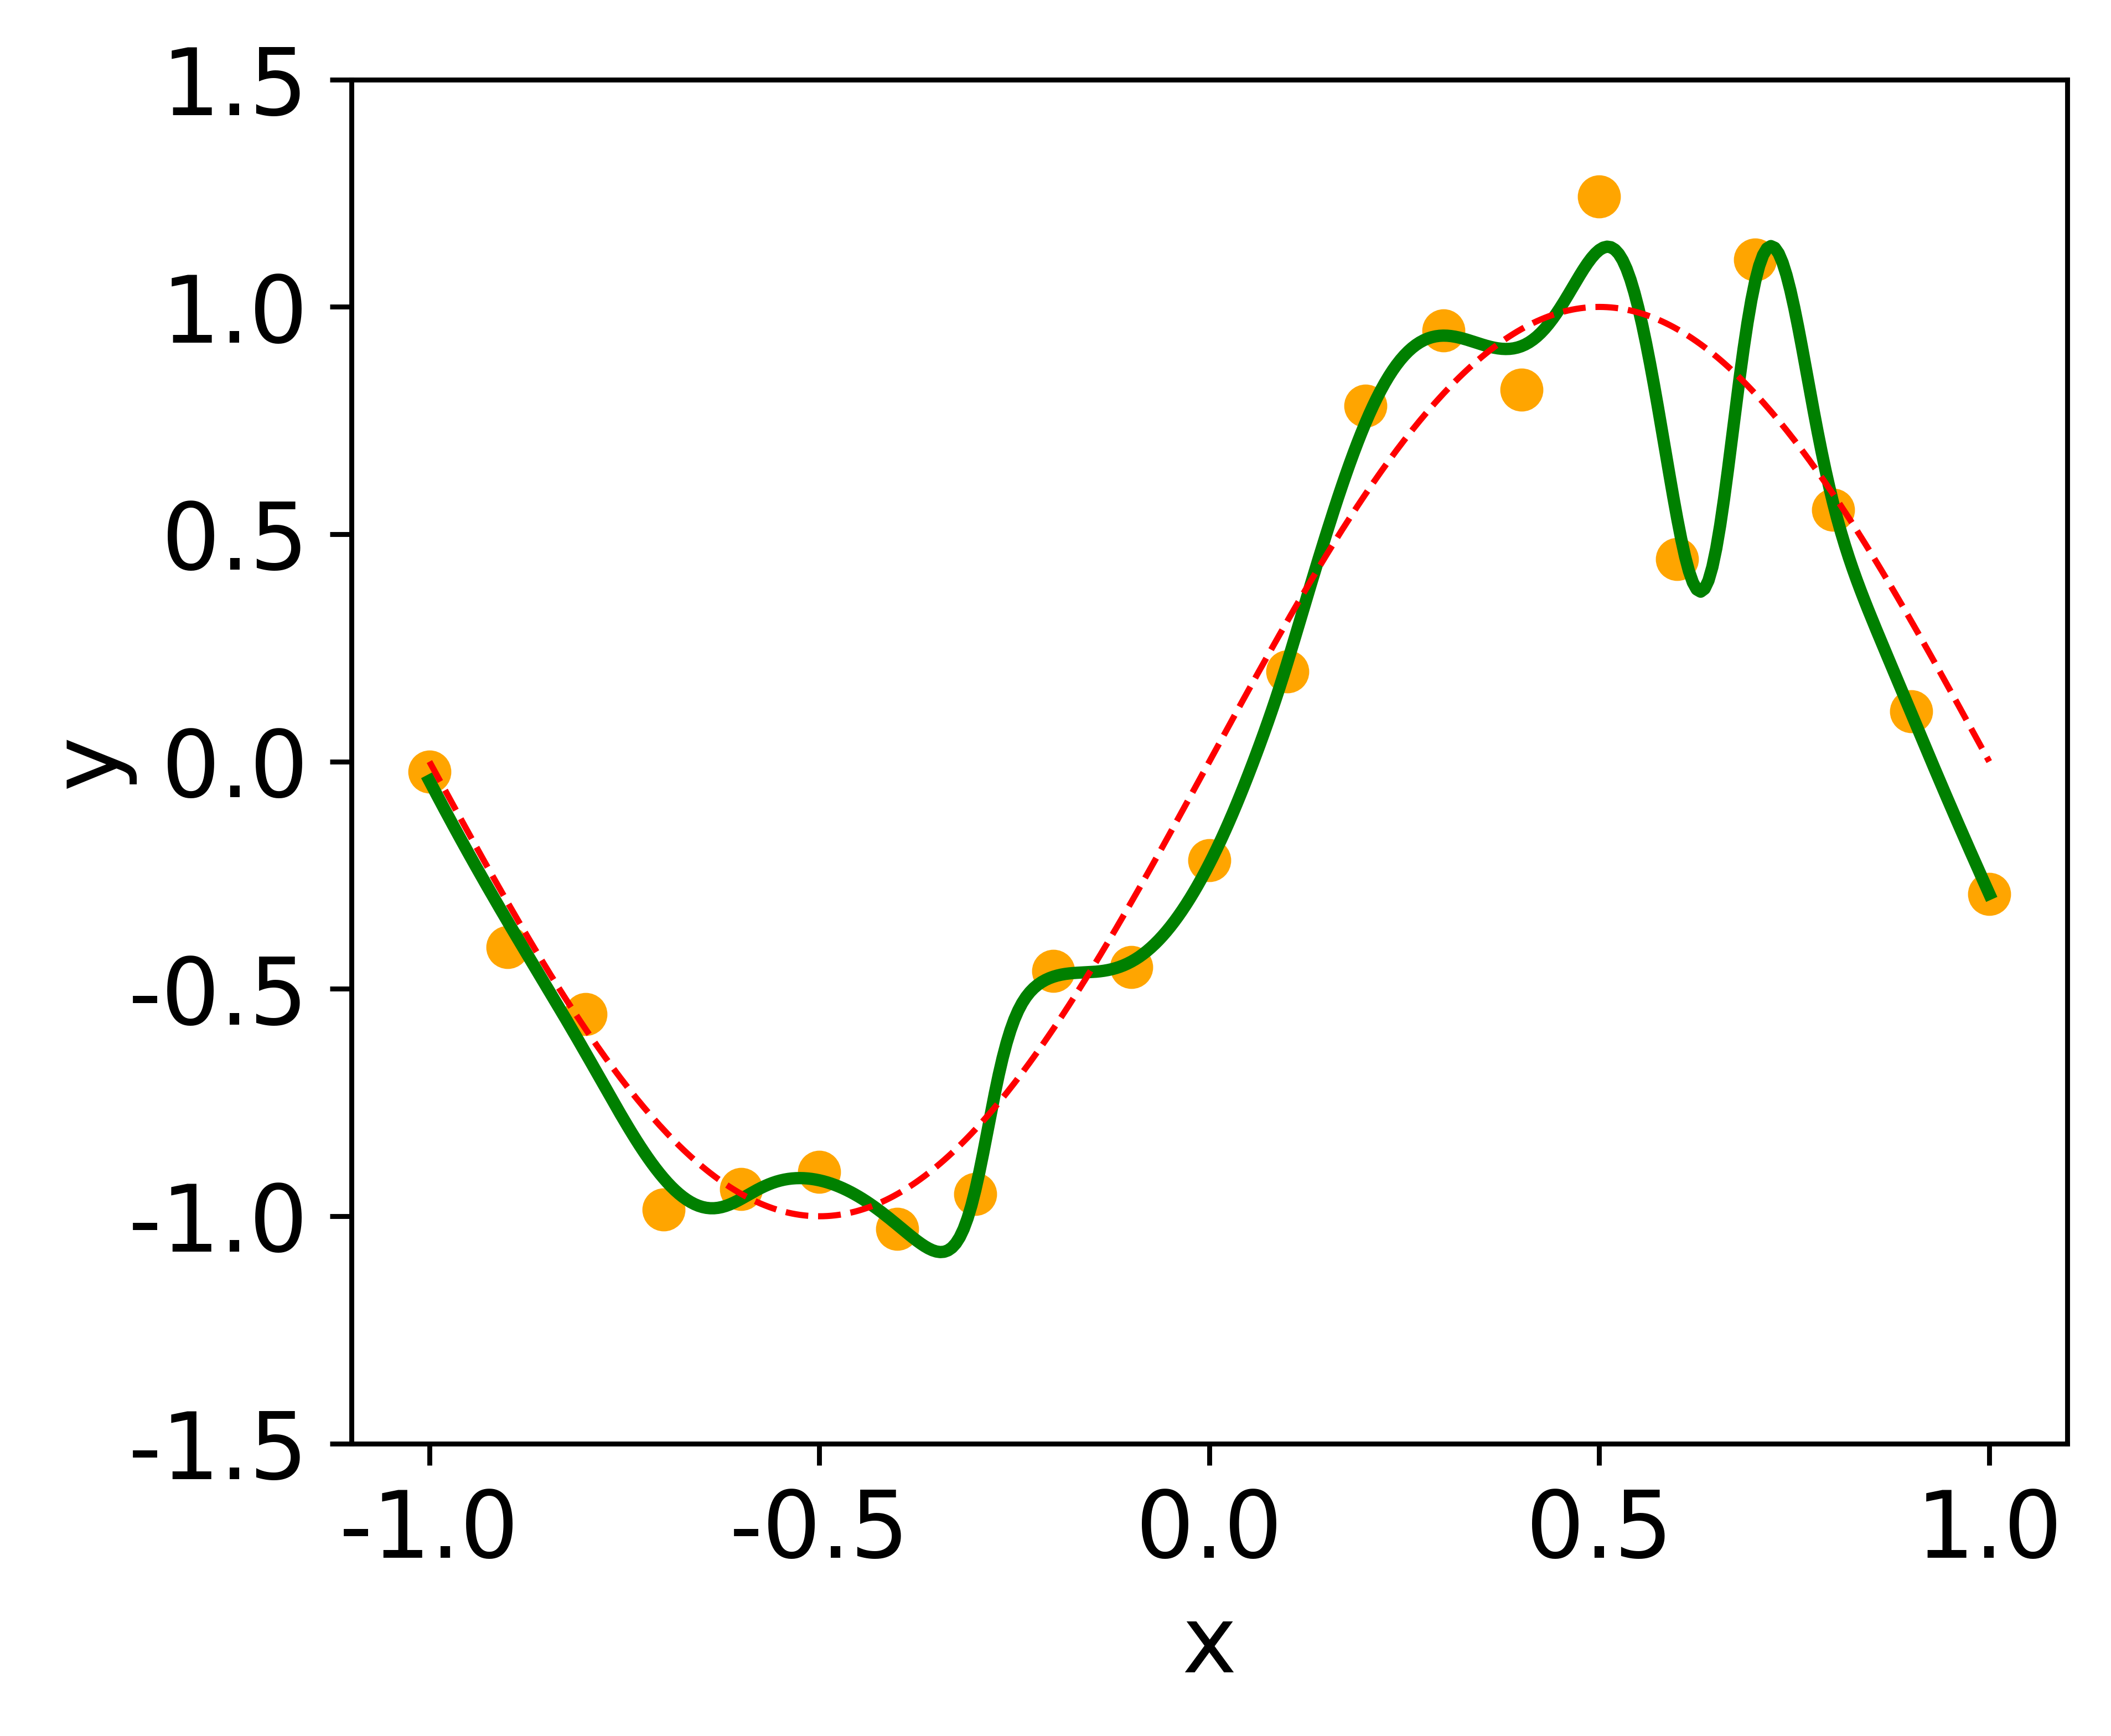

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
#plt.style.use(['science','ieee'])#如果找不到science plot包则载入这句话
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)
# 画出训练集来，是橘色的散点。
ax.scatter(x.data.numpy(), ytrain.data.numpy(), color="orange")
# NJnum次网络输出平均，因为x加入了NJnum次噪声进行了扰动
ax.plot(inputx.data.numpy(), output.data.numpy(), 'g-', lw=2)
#真实信号
signal = torch.sin(math.pi*inputx)
ax.plot(inputx.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')

In [6]:
####来一组继续测试
SEED = 666

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True
xtest = torch.unsqueeze(torch.linspace(-1, 1, 41), dim=1)
ytest = torch.sin(math.pi*xtest) + 0.2*torch.randn(xtest.size())
prediction3_subset = output[::10]
loss3 = loss_func(prediction3_subset, ytest) # 计算loss，通过prediction和y的差来计算mse
print(loss3.data)# 大约是10^{-2}次级别，与拟合的误差相比，泛化误差非常大，相差2个数量级

tensor(0.0542)


In [7]:
#loss 0.006274203718445884，测试0.0537 泛化误差大

In [9]:
#继续改变sigma的大小，不知道最优值sigma是多少

In [10]:
#选择sigma
from tqdm import tqdm

sigma = 0.1  # 人工选择加入噪声均方根为0.1
losses = []  # 用于存储每次训练的损失，共NJnum个
x = x.to(device)
inputx = torch.unsqueeze(torch.linspace(-1, 1, 401), dim=1).to(device)
output = torch.zeros(inputx.shape).to(device)


for num in range(NJnum):
    
    SEED = 1234 + 12 * num  
    np.random.seed(SEED)
    random.seed(SEED) 
    
    #x_noisy = x + sigma * torch.randn(x.size()).to(device)
    #ytrain = ytrain.to(device)#这是噪声注入x的代码
    
    y_noisy = ytrain + sigma * torch.randn(x.size()).to(device)
    #改变y，就是噪声注入标签
    progress_bar = tqdm(range(epoch), desc=f'NJnum {num}/{NJnum}')
    net.reset_parameters()
    for t in progress_bar:
        prediction = net(x)
        loss = loss_func(prediction, y_noisy)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        if t % 200 == 0:
            progress_bar.set_postfix({'loss': loss.item()})
    #epoch=20000步之后网络输出和最后一步训练之后的loss
    response = net(inputx)
    output += response
    losses.append(loss.item())  # 记录每次训练的损失
# 平均损失
average_loss = sum(losses) / NJnum
print("average_loss =", average_loss)
#平均网络输出
output /= NJnum

NJnum 29/30: 100%|████████████████████████████████████████████████| 20000/20000 [00:16<00:00, 1219.66it/s, loss=0.0105]

average_loss = 0.004819822376005808


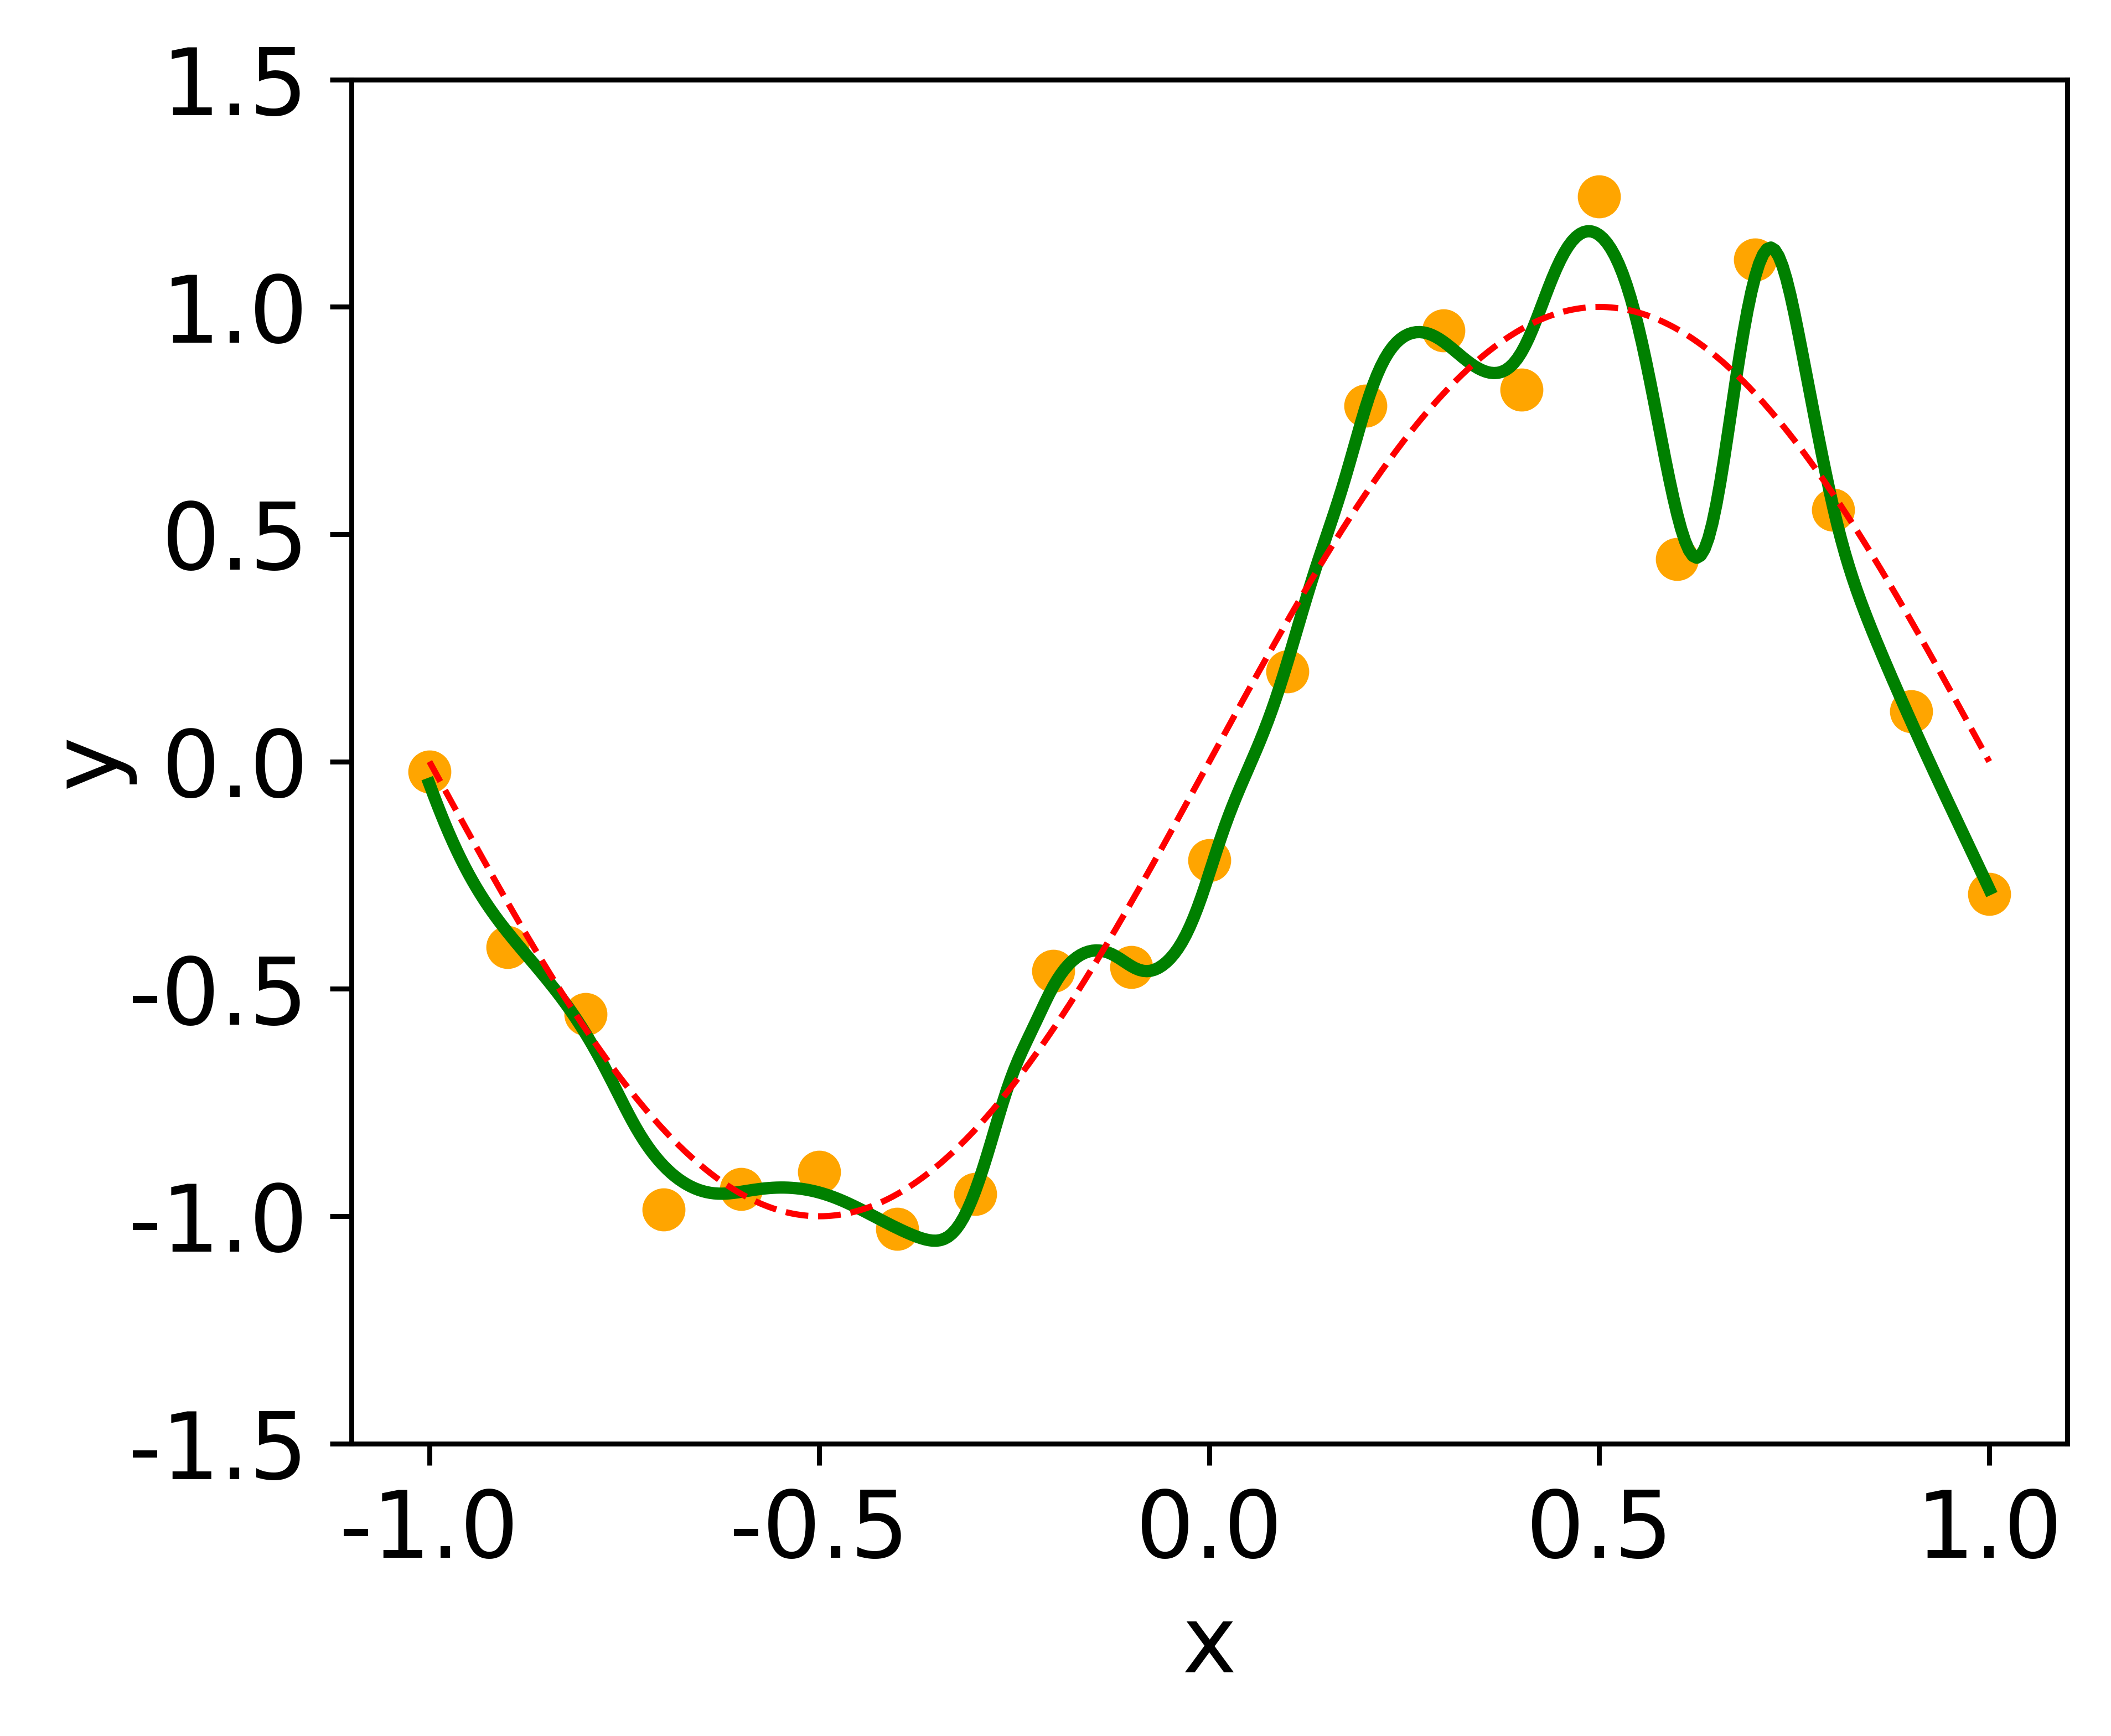

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
#plt.style.use(['science','ieee'])#如果找不到science plot包则载入这句话
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)
# 画出训练集来，是橘色的散点。
ax.scatter(x.data.numpy(), ytrain.data.numpy(), color="orange")
# NJnum次网络输出平均，因为x加入了NJnum次噪声进行了扰动
ax.plot(inputx.data.numpy(), output.data.numpy(), 'g-', lw=2)
#真实信号
signal = torch.sin(math.pi*inputx)
ax.plot(inputx.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')

In [12]:
####来一组继续测试
SEED = 666

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True
xtest = torch.unsqueeze(torch.linspace(-1, 1, 41), dim=1)
ytest = torch.sin(math.pi*xtest) + 0.2*torch.randn(xtest.size())
prediction3_subset = output[::10]
loss3 = loss_func(prediction3_subset, ytest) # 计算loss，通过prediction和y的差来计算mse
print(loss3.data)# 大约是10^{-2}次级别

tensor(0.0567)


In [13]:
#选择sigma
from tqdm import tqdm

sigma = 0.3  # 人工选择加入噪声均方根为0.1
losses = []  # 用于存储每次训练的损失，共NJnum个
x = x.to(device)
inputx = torch.unsqueeze(torch.linspace(-1, 1, 401), dim=1).to(device)
output = torch.zeros(inputx.shape).to(device)


for num in range(NJnum):
    
    SEED = 1234 + 12 * num  
    np.random.seed(SEED)
    random.seed(SEED) 
    
    #x_noisy = x + sigma * torch.randn(x.size()).to(device)
    #ytrain = ytrain.to(device)#这是噪声注入x的代码
    
    y_noisy = ytrain + sigma * torch.randn(x.size()).to(device)
    #改变y，就是噪声注入标签
    progress_bar = tqdm(range(epoch), desc=f'NJnum {num}/{NJnum}')
    net.reset_parameters()
    for t in progress_bar:
        prediction = net(x)
        loss = loss_func(prediction, y_noisy)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        if t % 200 == 0:
            progress_bar.set_postfix({'loss': loss.item()})
    #epoch=20000步之后网络输出和最后一步训练之后的loss
    response = net(inputx)
    output += response
    losses.append(loss.item())  # 记录每次训练的损失
# 平均损失
average_loss = sum(losses) / NJnum
print("average_loss =", average_loss)
#平均网络输出
output /= NJnum

NJnum 29/30: 100%|██████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1582.51it/s, loss=0.000739]

average_loss = 0.007674987226619123


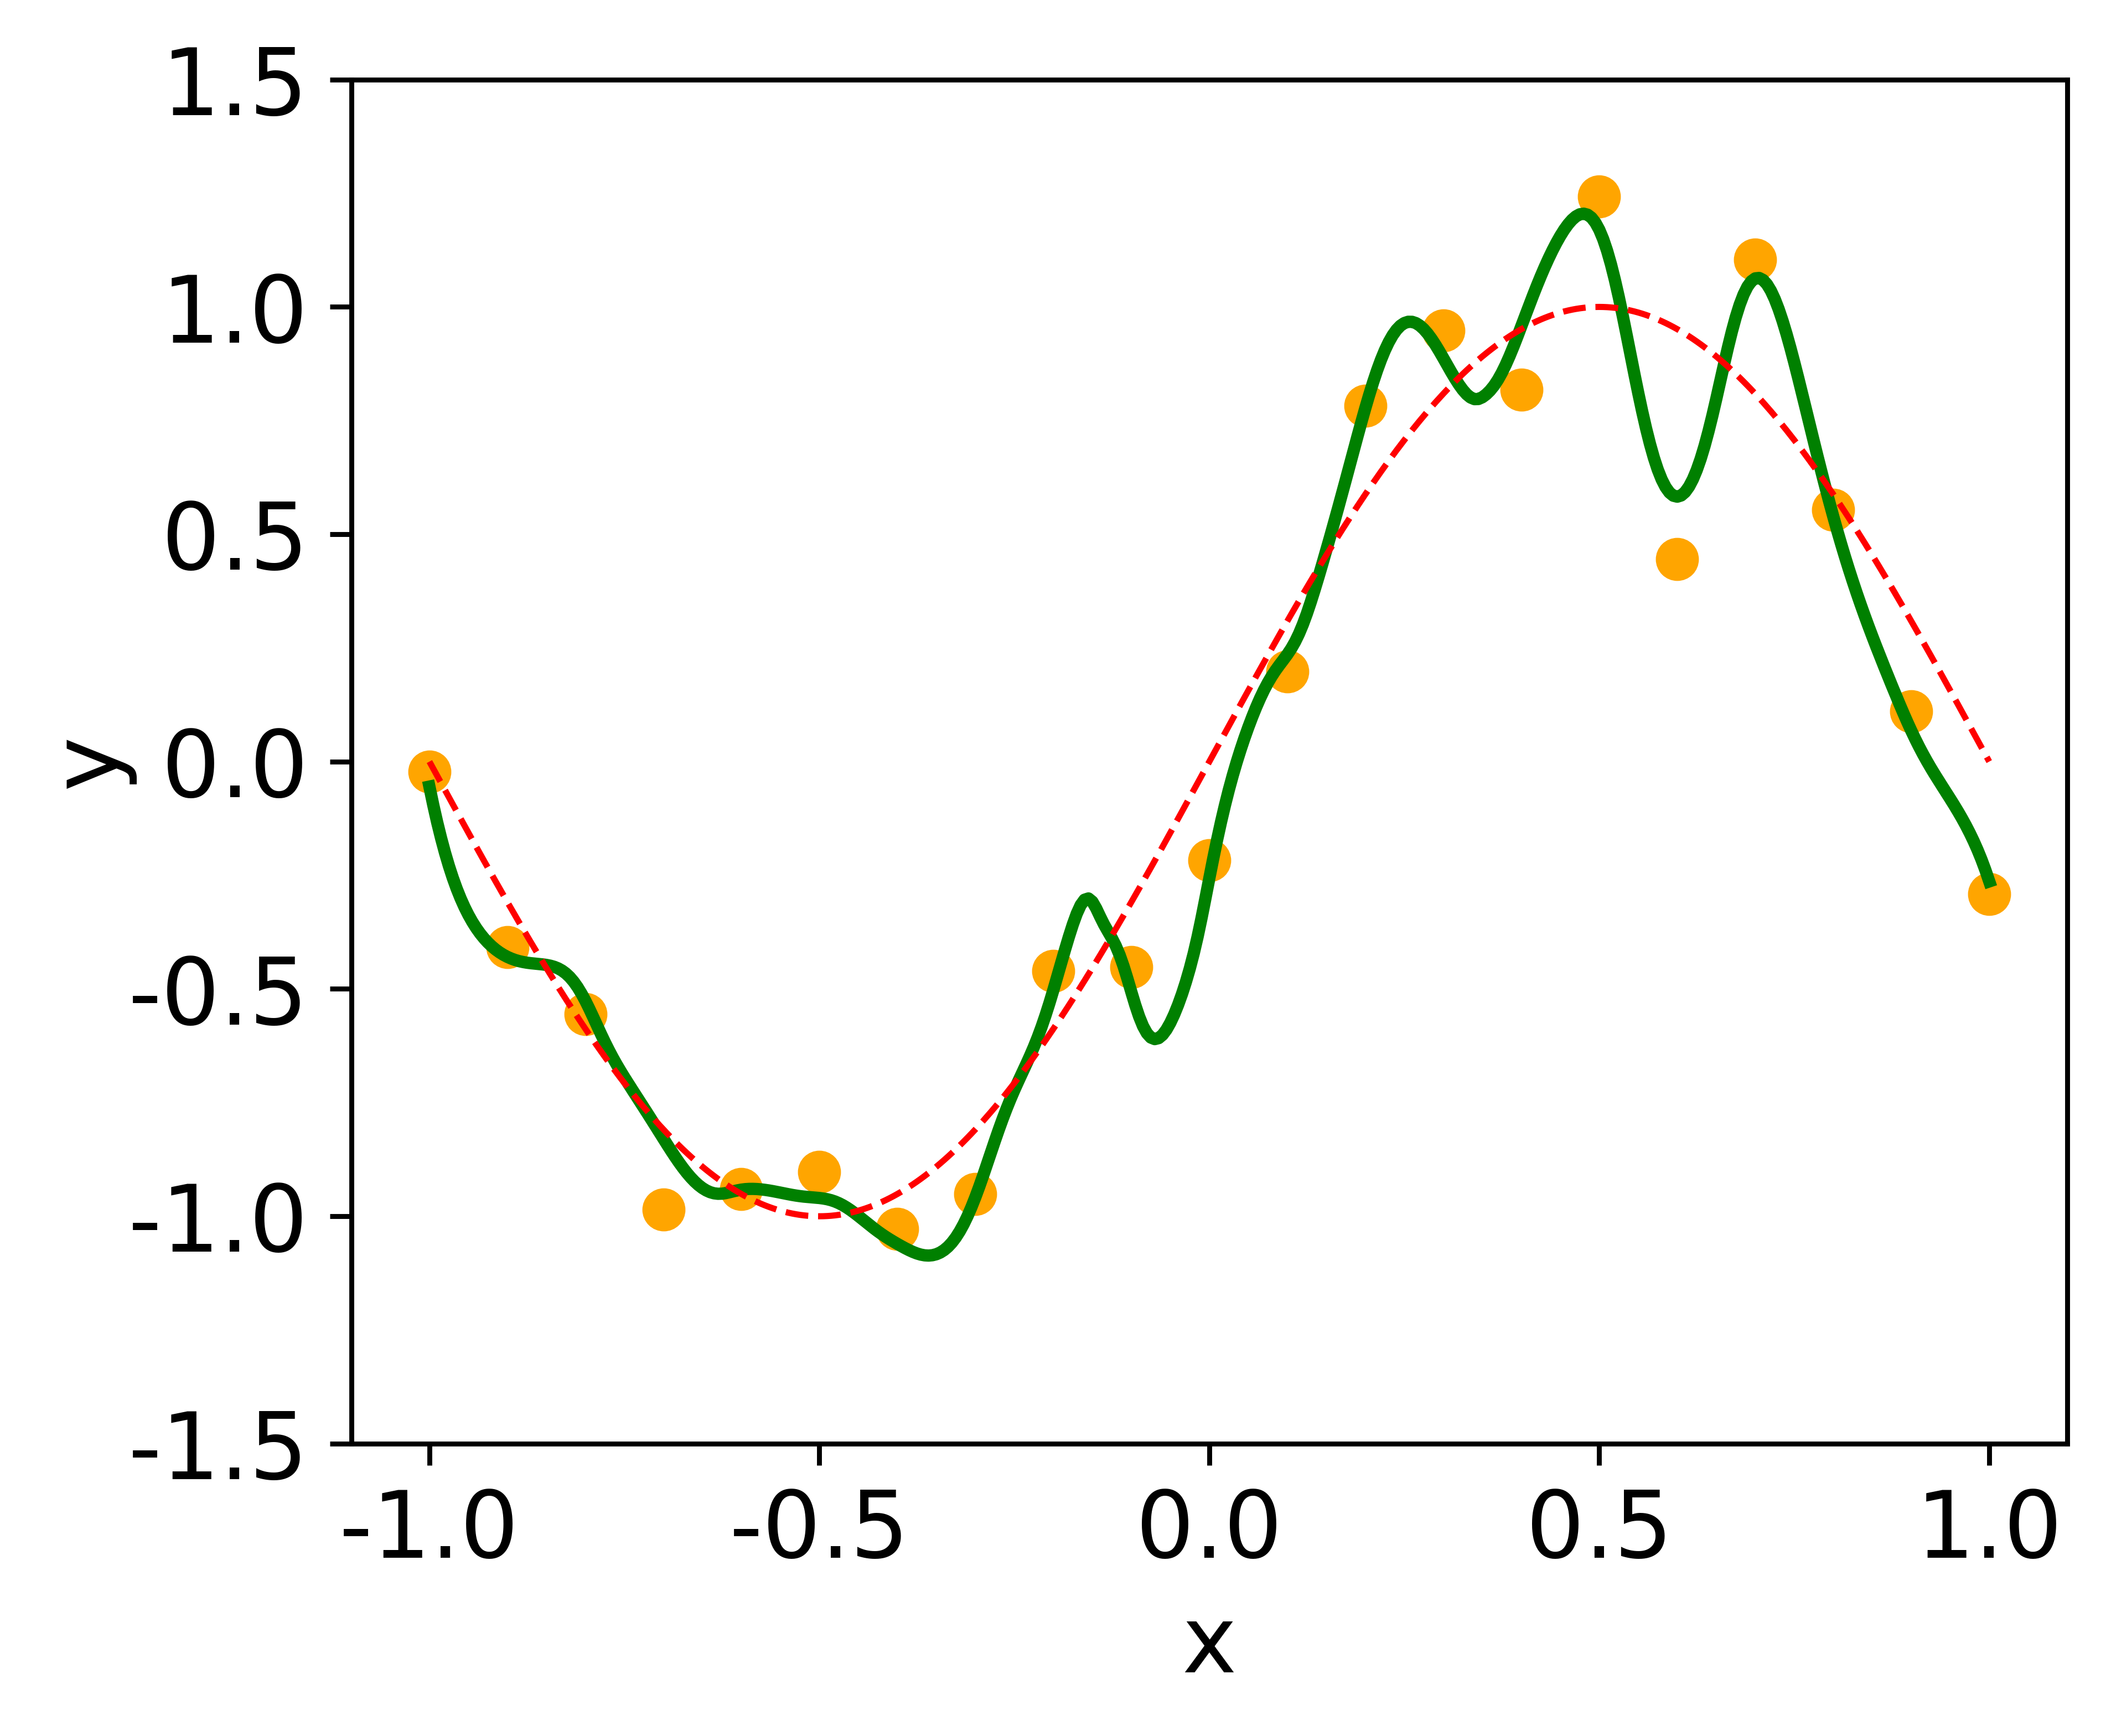

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
#plt.style.use(['science','ieee'])#如果找不到science plot包则载入这句话
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)
# 画出训练集来，是橘色的散点。
ax.scatter(x.data.numpy(), ytrain.data.numpy(), color="orange")
# NJnum次网络输出平均，因为x加入了NJnum次噪声进行了扰动
ax.plot(inputx.data.numpy(), output.data.numpy(), 'g-', lw=2)
#真实信号
signal = torch.sin(math.pi*inputx)
ax.plot(inputx.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')

In [15]:
####来一组继续测试
SEED = 666

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True
xtest = torch.unsqueeze(torch.linspace(-1, 1, 41), dim=1)
ytest = torch.sin(math.pi*xtest) + 0.2*torch.randn(xtest.size())
prediction3_subset = output[::10]
loss3 = loss_func(prediction3_subset, ytest) # 计算loss，通过prediction和y的差来计算mse
print(loss3.data)# 大约是10^{-2}次级别

tensor(0.0636)


In [17]:
#与加入x不一样，sigma继续增加
#选择sigma
from tqdm import tqdm

sigma = 0.6  # 人工选择加入噪声均方根为0.1
losses = []  # 用于存储每次训练的损失，共NJnum个
x = x.to(device)
inputx = torch.unsqueeze(torch.linspace(-1, 1, 401), dim=1).to(device)
output = torch.zeros(inputx.shape).to(device)


for num in range(NJnum):
    
    SEED = 1234 + 12 * num  
    np.random.seed(SEED)
    random.seed(SEED) 
    
    #x_noisy = x + sigma * torch.randn(x.size()).to(device)
    #ytrain = ytrain.to(device)#这是噪声注入x的代码
    
    y_noisy = ytrain + sigma * torch.randn(x.size()).to(device)
    #改变y，就是噪声注入标签
    progress_bar = tqdm(range(epoch), desc=f'NJnum {num}/{NJnum}')
    net.reset_parameters()
    for t in progress_bar:
        prediction = net(x)
        loss = loss_func(prediction, y_noisy)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        if t % 200 == 0:
            progress_bar.set_postfix({'loss': loss.item()})
    #epoch=20000步之后网络输出和最后一步训练之后的loss
    response = net(inputx)
    output += response
    losses.append(loss.item())  # 记录每次训练的损失
# 平均损失
average_loss = sum(losses) / NJnum
print("average_loss =", average_loss)
#平均网络输出
output /= NJnum

NJnum 29/30: 100%|████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1567.16it/s, loss=0.0772]

average_loss = 0.027402392950352805


tensor(0.0894)


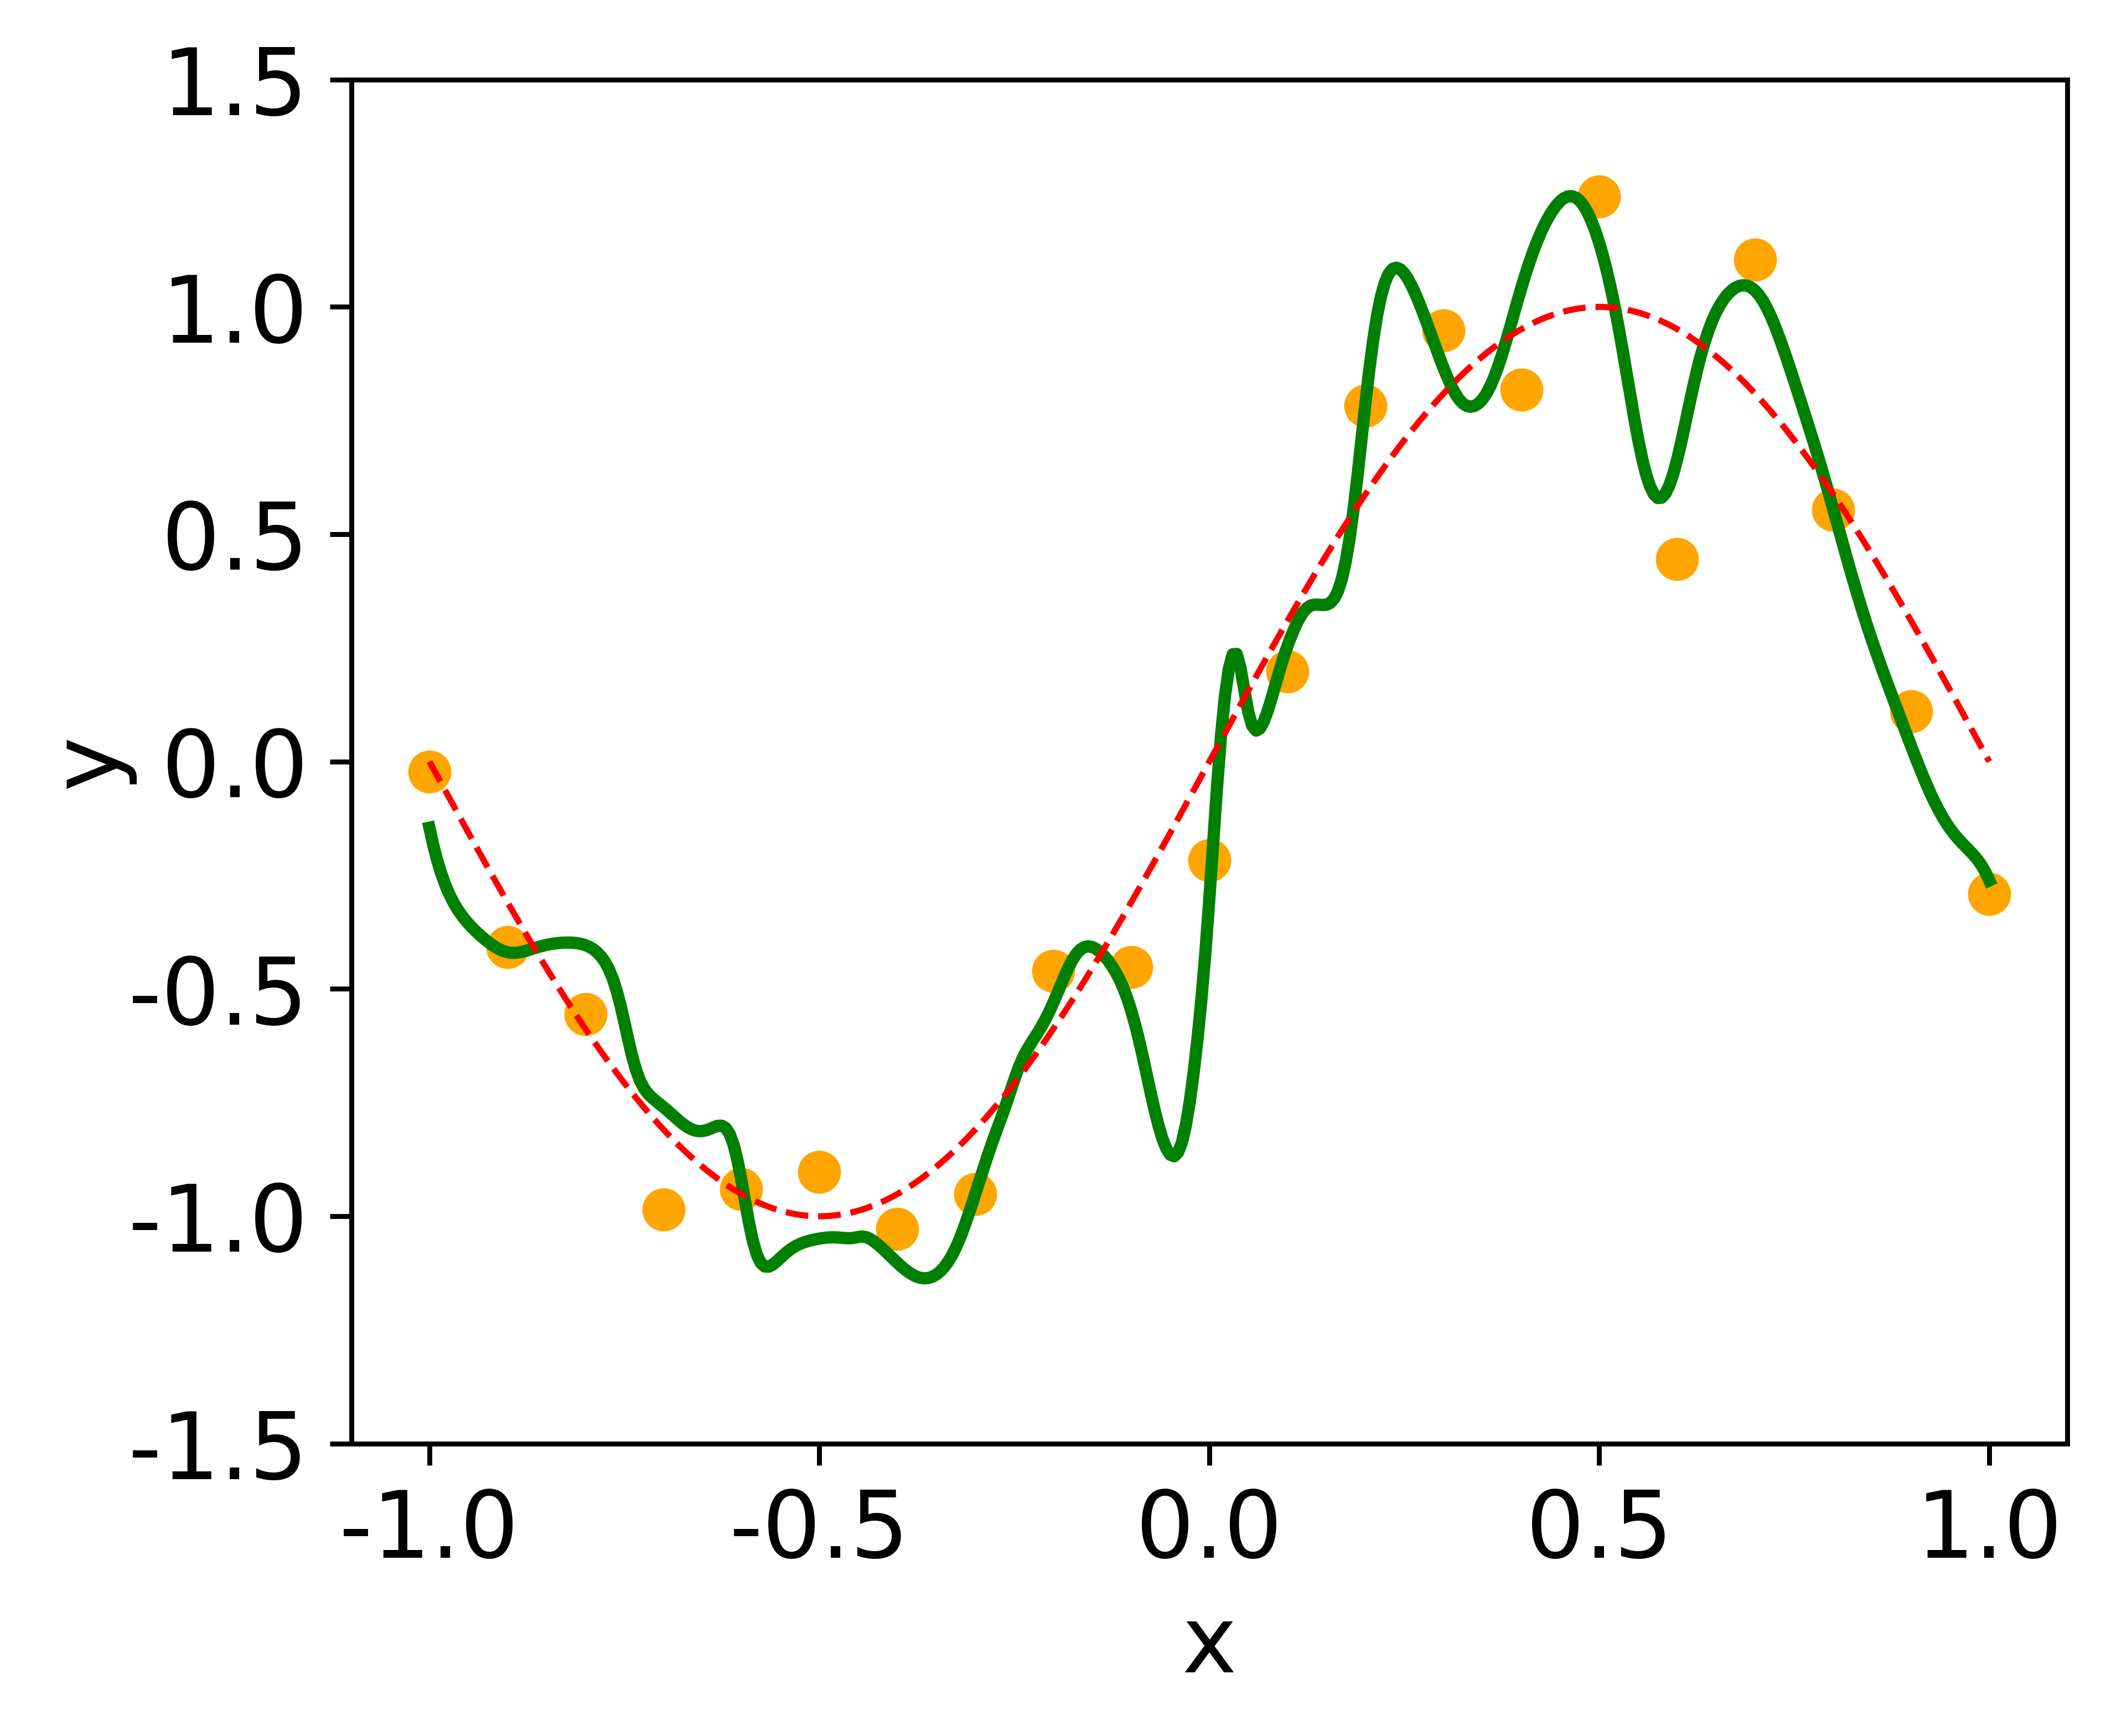

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
#plt.style.use(['science','ieee'])#如果找不到science plot包则载入这句话
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)
# 画出训练集来，是橘色的散点。
ax.scatter(x.data.numpy(), ytrain.data.numpy(), color="orange")
# NJnum次网络输出平均，因为x加入了NJnum次噪声进行了扰动
ax.plot(inputx.data.numpy(), output.data.numpy(), 'g-', lw=2)
#真实信号
signal = torch.sin(math.pi*inputx)
ax.plot(inputx.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')
####来一组继续测试
SEED = 666

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True
xtest = torch.unsqueeze(torch.linspace(-1, 1, 41), dim=1)
ytest = torch.sin(math.pi*xtest) + 0.2*torch.randn(xtest.size())
prediction3_subset = output[::10]
loss3 = loss_func(prediction3_subset, ytest) # 计算loss，通过prediction和y的差来计算mse
print(loss3.data)# 大约是10^{-2}次级别

In [19]:
#改善还是不大，特别是波形很奇怪

NJnum 29/30: 100%|████████████████████████████████████████████████| 20000/20000 [00:13<00:00, 1446.58it/s, loss=0.0977]


average_loss = 0.06066751003563695
tensor(0.1154)


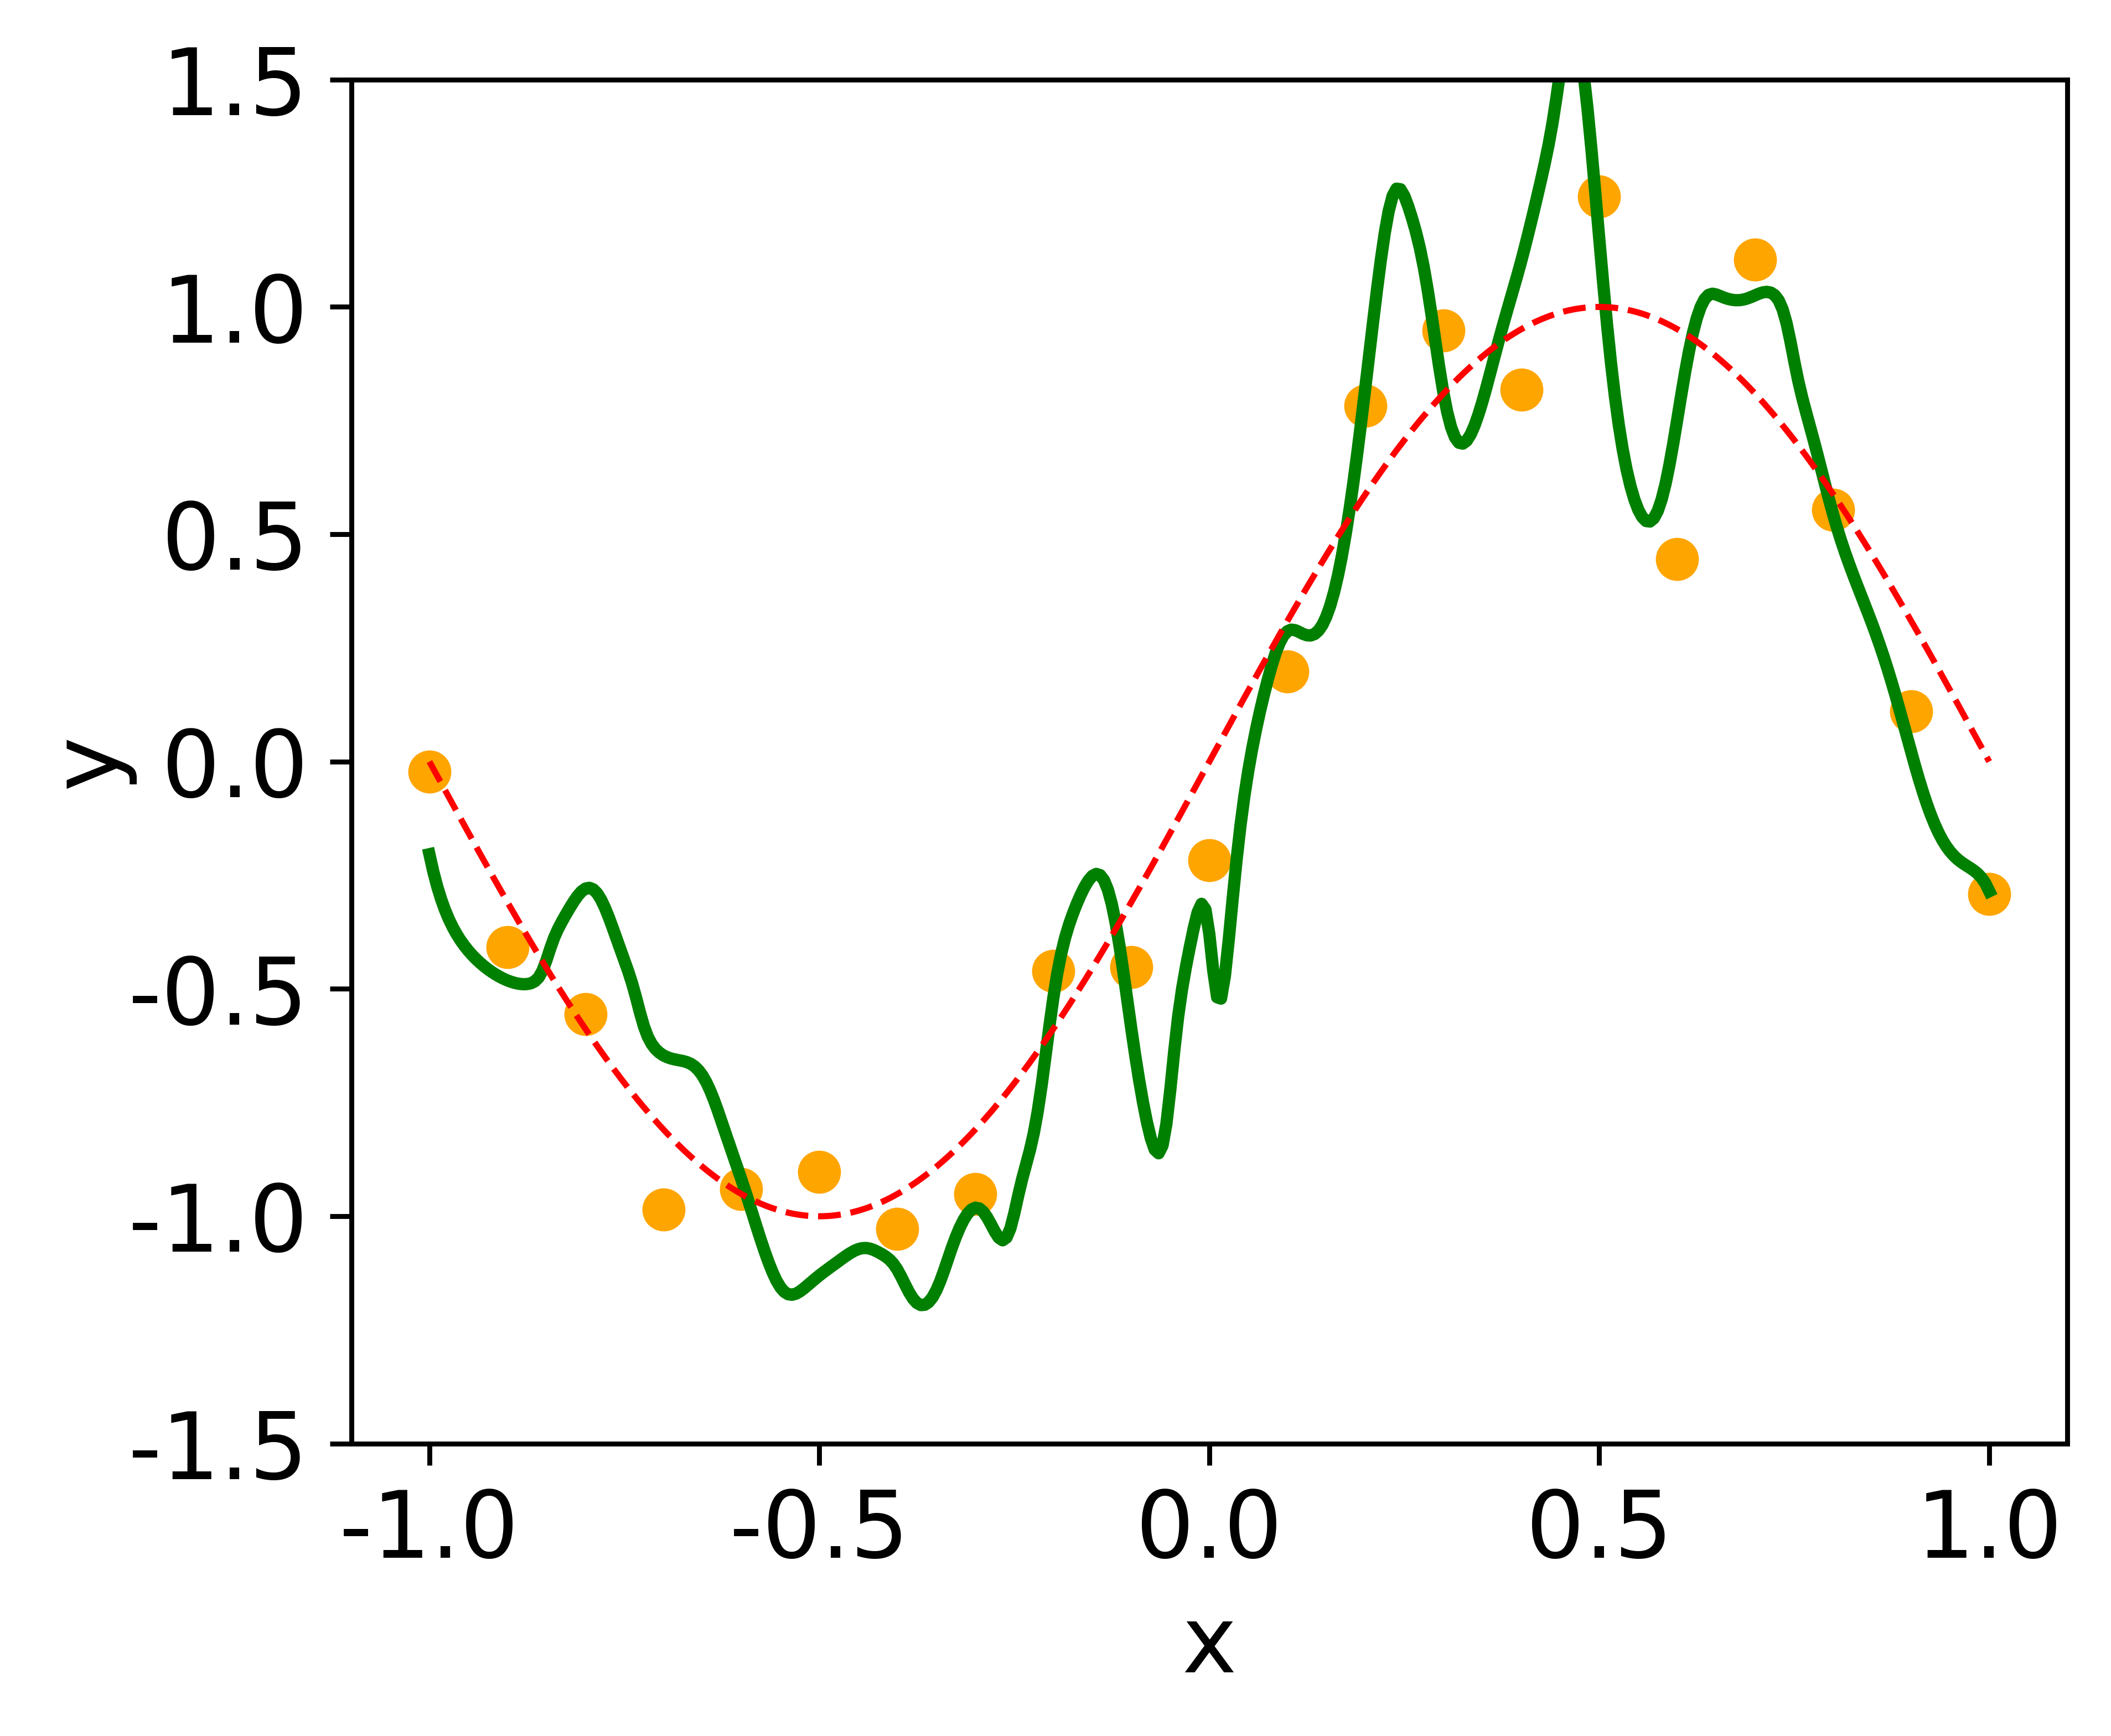

In [20]:
#与加入x不一样，sigma继续增加
#选择sigma
from tqdm import tqdm

sigma = 0.9  # 人工选择加入噪声均方根为0.1
losses = []  # 用于存储每次训练的损失，共NJnum个
x = x.to(device)
inputx = torch.unsqueeze(torch.linspace(-1, 1, 401), dim=1).to(device)
output = torch.zeros(inputx.shape).to(device)


for num in range(NJnum):
    
    SEED = 1234 + 12 * num  
    np.random.seed(SEED)
    random.seed(SEED) 
    
    #x_noisy = x + sigma * torch.randn(x.size()).to(device)
    #ytrain = ytrain.to(device)#这是噪声注入x的代码
    
    y_noisy = ytrain + sigma * torch.randn(x.size()).to(device)
    #改变y，就是噪声注入标签
    progress_bar = tqdm(range(epoch), desc=f'NJnum {num}/{NJnum}')
    net.reset_parameters()
    for t in progress_bar:
        prediction = net(x)
        loss = loss_func(prediction, y_noisy)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        if t % 200 == 0:
            progress_bar.set_postfix({'loss': loss.item()})
    #epoch=20000步之后网络输出和最后一步训练之后的loss
    response = net(inputx)
    output += response
    losses.append(loss.item())  # 记录每次训练的损失
# 平均损失
average_loss = sum(losses) / NJnum
print("average_loss =", average_loss)
#平均网络输出
output /= NJnum

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
#plt.style.use(['science','ieee'])#如果找不到science plot包则载入这句话
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)
# 画出训练集来，是橘色的散点。
ax.scatter(x.data.numpy(), ytrain.data.numpy(), color="orange")
# NJnum次网络输出平均，因为x加入了NJnum次噪声进行了扰动
ax.plot(inputx.data.numpy(), output.data.numpy(), 'g-', lw=2)
#真实信号
signal = torch.sin(math.pi*inputx)
ax.plot(inputx.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')
####来一组继续测试
SEED = 666

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True
xtest = torch.unsqueeze(torch.linspace(-1, 1, 41), dim=1)
ytest = torch.sin(math.pi*xtest) + 0.2*torch.randn(xtest.size())
prediction3_subset = output[::10]
loss3 = loss_func(prediction3_subset, ytest) # 计算loss，通过prediction和y的差来计算mse
print(loss3.data)# 大约是10^{-2}次级别

In [21]:
#结论就是有所改进，比较光滑的拟合曲线不太容易得到，效果有限！！！